In [1]:
import sys
from scipy import ndimage
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import seaborn as sns
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from collections import namedtuple

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# how large should the image be
SIZE = 16

# labels every
LABELS = 5

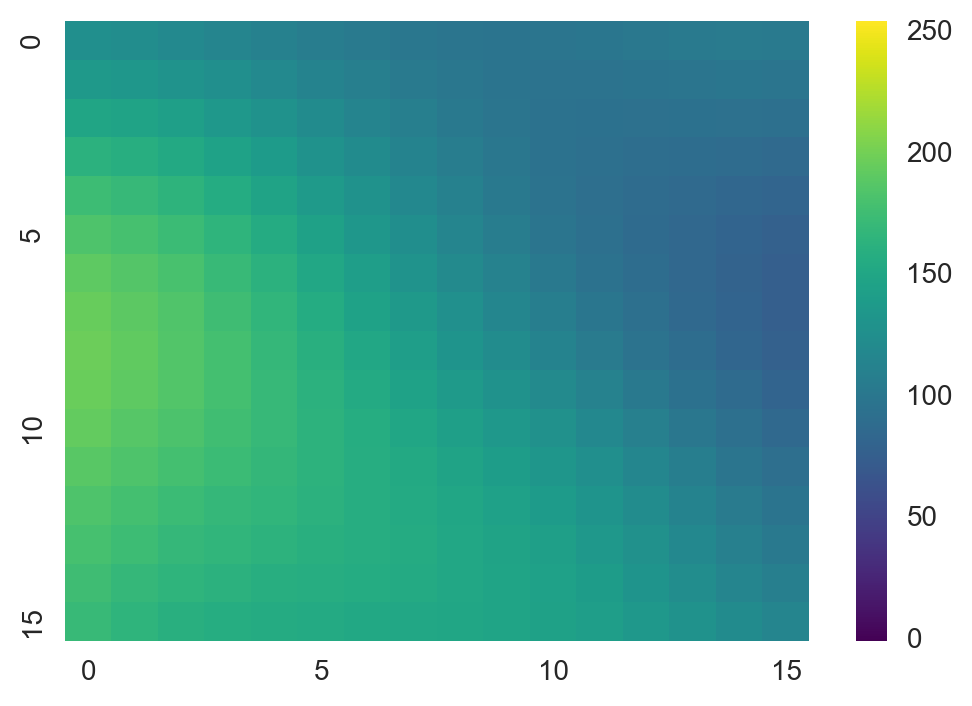

In [3]:
values = ndimage.imread('img/noise1.png', flatten=True)[0:SIZE,0:SIZE]
sns.heatmap(values, cmap='viridis', vmin=0, vmax=255, xticklabels=LABELS, yticklabels=LABELS)

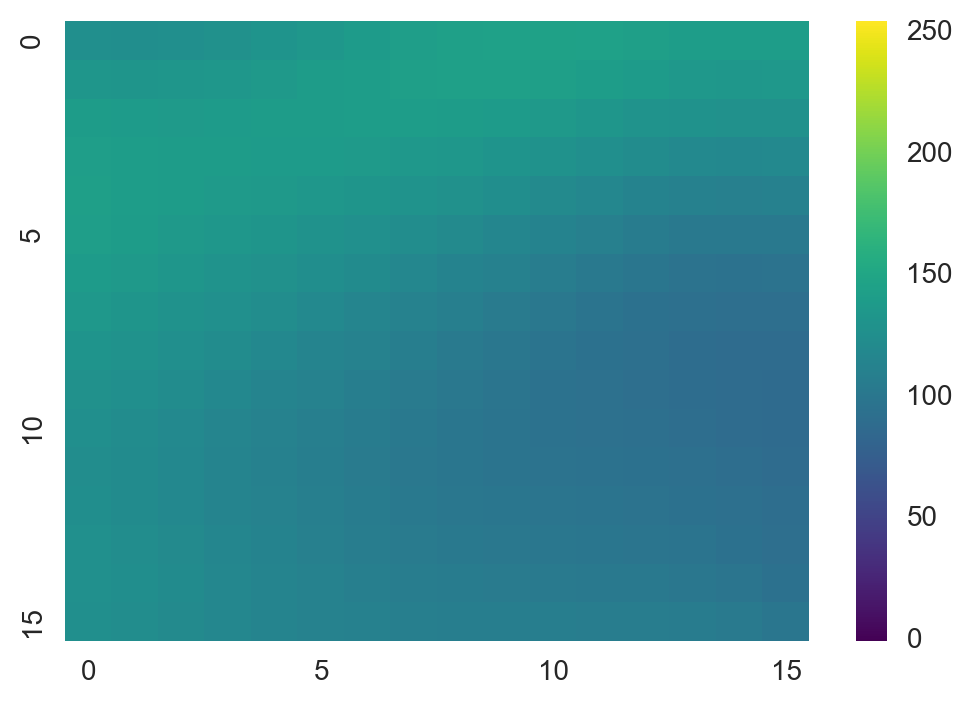

In [4]:
counts = ndimage.imread('img/noise2.png', flatten=True)[0:SIZE,0:SIZE]
sns.heatmap(counts, cmap='viridis', vmin=0, vmax=255, xticklabels=LABELS, yticklabels=LABELS)

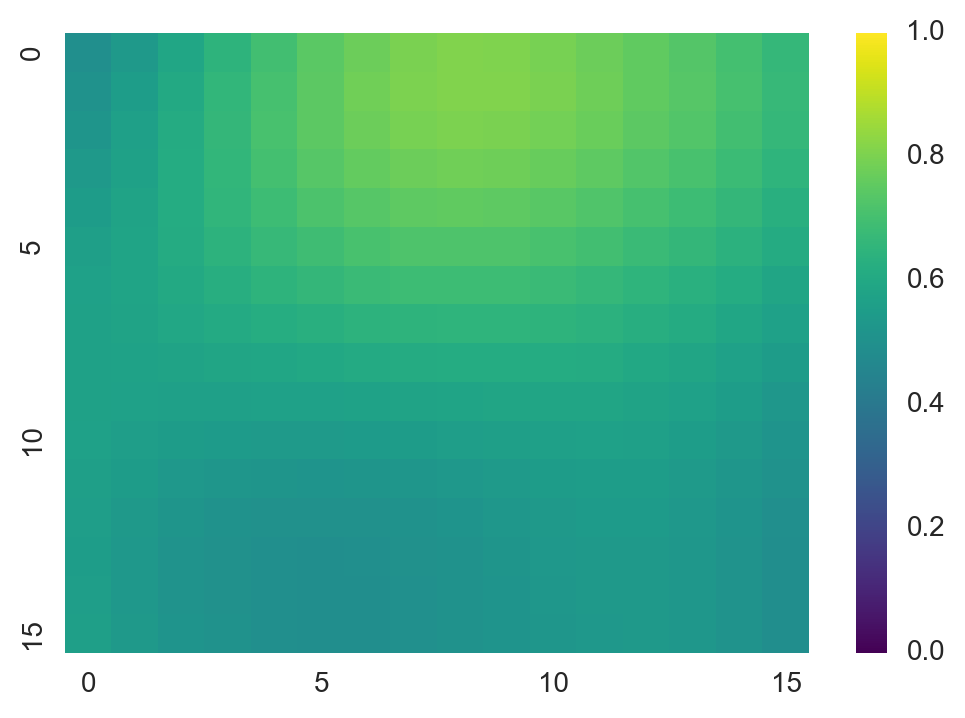

In [5]:
uncertainties = ndimage.imread('img/noise3.png', flatten=True)[0:SIZE,0:SIZE]/255
sns.heatmap(uncertainties, cmap='viridis', vmin=0, vmax=1, xticklabels=LABELS, yticklabels=LABELS)

In [6]:
w = values.shape[0]
h = values.shape[1]

ids = np.arange(w*h).reshape(values.shape)

In [7]:
# data structure to help us keep track of which cells are in a contracted node
Cell = namedtuple('Cell', ['x', 'y'])

G = nx.Graph()

# create nodes
for x in range(w):
    for y in range(h):
        c = Cell(x, y)
        G.add_node(y*w+x, cells=set([c]), v=values[x][y], c=counts[x][y], u=uncertainties[x][y])

# create edges
for x in range(w):
    for y in range(h):
        if (x+1<w):
            G.add_edge(y*w+x, y*w+x+1)
        if (y+1<h):
            G.add_edge(y*w+x, (y+1)*w+x)

# print some stats to check for sanity
G.number_of_nodes(), G.number_of_edges(), G.node[0]

(256,
 480,
 {'c': 126.0, 'cells': {Cell(x=0, y=0)}, 'u': 0.49411765, 'v': 126.0})

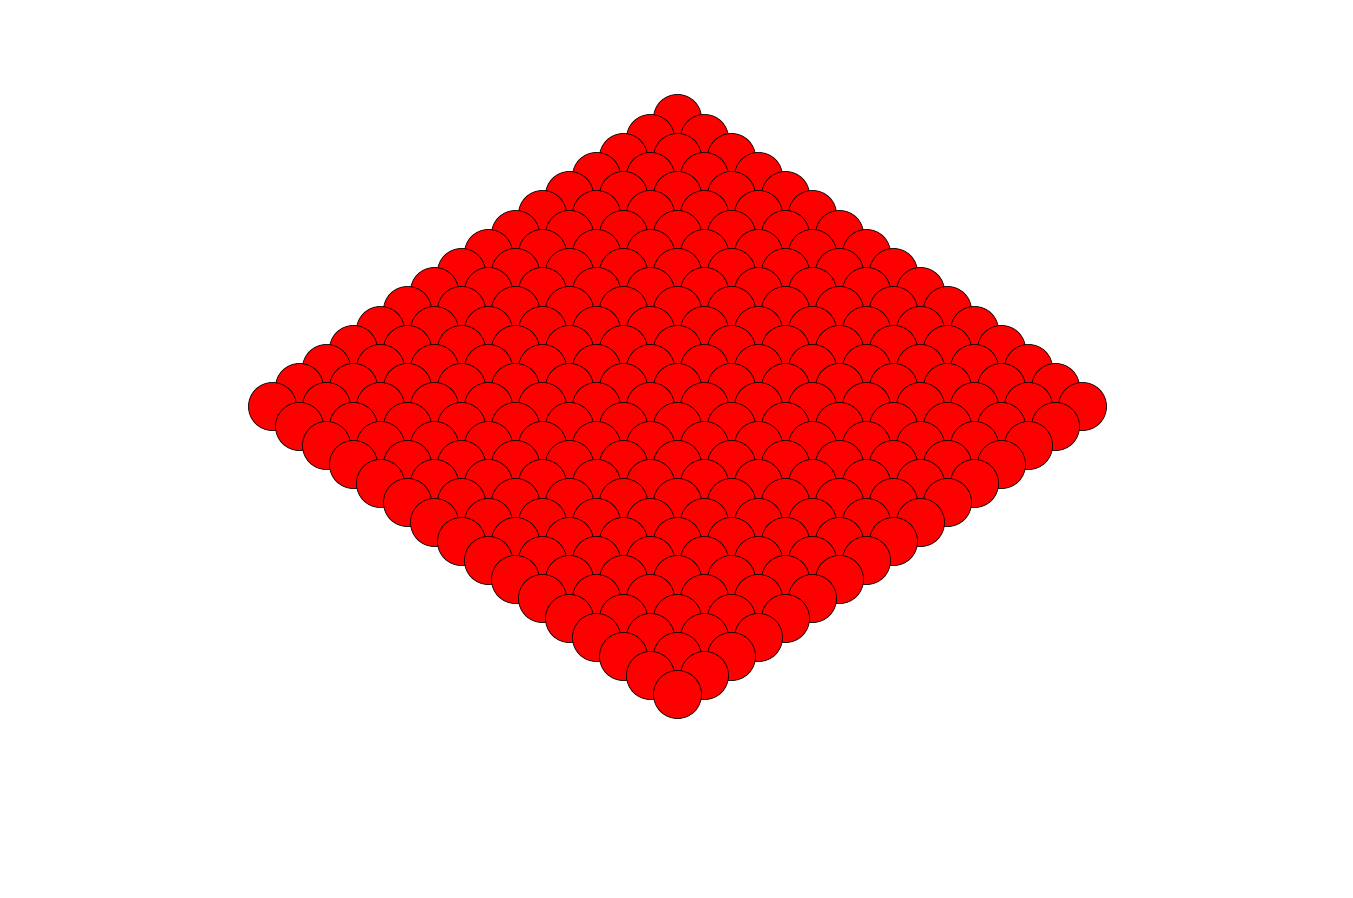

In [8]:
positions = graphviz_layout(G, prog='dot')
nx.draw(G, pos=positions)

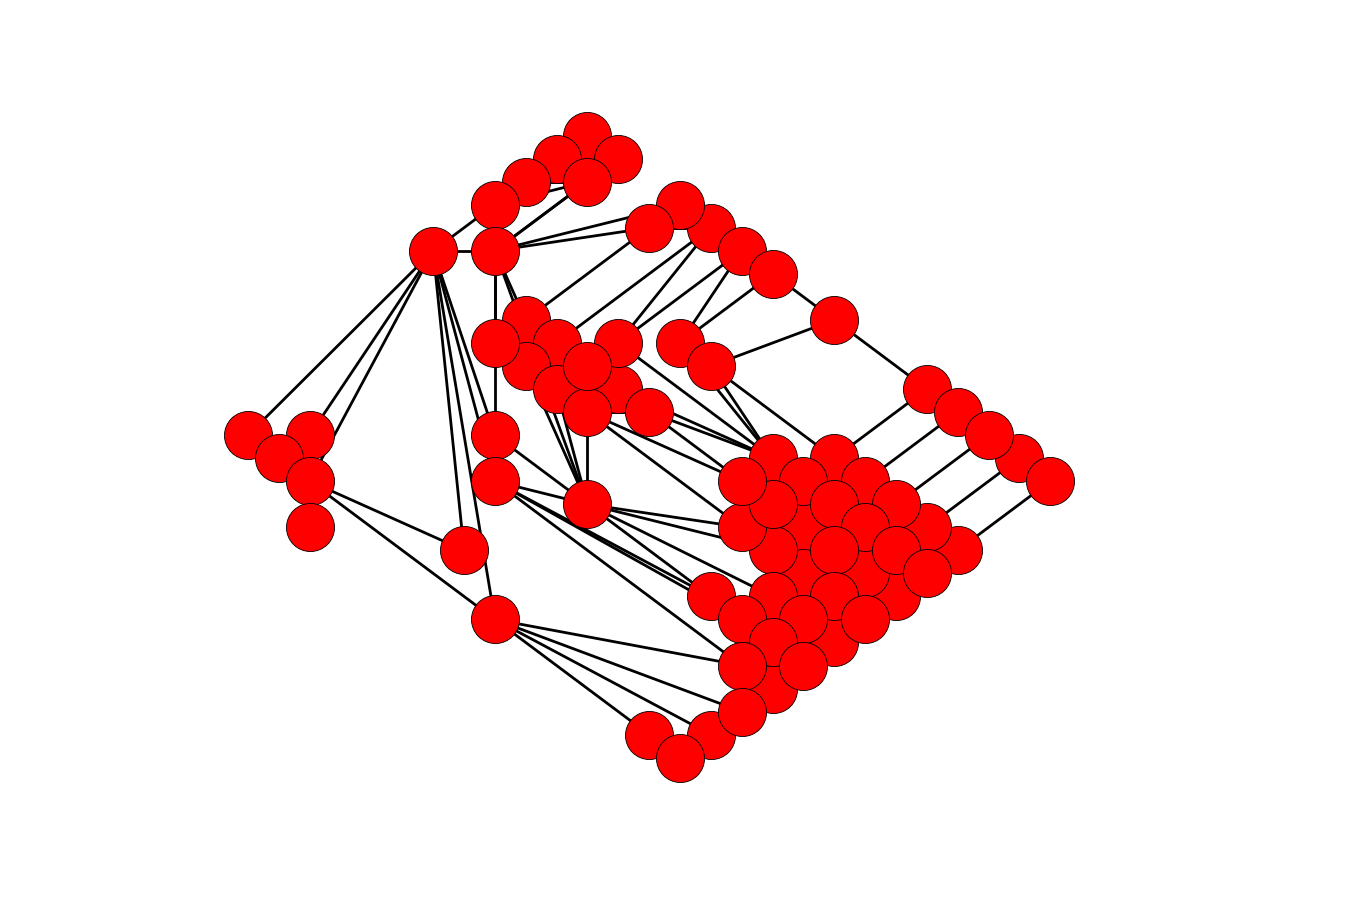

In [9]:
def merge(edge, graph):
    """Merges two nodes and combines the count, value, uncertainty, and cells"""
    s = graph.node[edge[0]]
    t = graph.node[edge[1]]
    count = s['c'] + t['c']
    value = (s['v'] * s['c']  + t['v'] * t['c']) / (s['c'] + t['c'])
    uncertainty = (s['u'] * (s['c'] - 1) + t['u'] * (t['c'] - 1)) / (s['c'] + t['c'] - 2)
    cells = s['cells'].union(t['cells'])
    
    H = nx.contracted_edge(graph, edge, self_loops=False)
    new_node = H.node[edge[0]]
    new_node['c'] = count
    new_node['v'] = value
    new_node['u'] = uncertainty
    new_node['cells'] = cells
    
    return H

def uncertainty_diff(edge):
    """Absolute difference in uncertainty"""
    return abs(G.node[edge[0]]['u'] - G.node[edge[1]]['u'])

# contracted graph
CG = G

for x in range(180):
    # find the next edge to contract
    best_edge = min(CG.edges(), key=uncertainty_diff)
    CG = merge(best_edge, CG)

nx.draw(CG, pos=positions)

In [10]:
# set the values form the graph back on the images

rand_ids = np.arange(len(CG))
np.random.shuffle(rand_ids)
CG = nx.convert_node_labels_to_integers(CG)

for node_id in CG.nodes():
    node = CG.node[node_id]
    for cell in node['cells']:
        counts[cell.x,cell.y] = node['c']
        values[cell.x,cell.y] = node['v']
        uncertainties[cell.x,cell.y] = node['u']

        # use shuffled ids so we can see differences in the ids
        ids[cell.x,cell.y] = rand_ids[node_id]

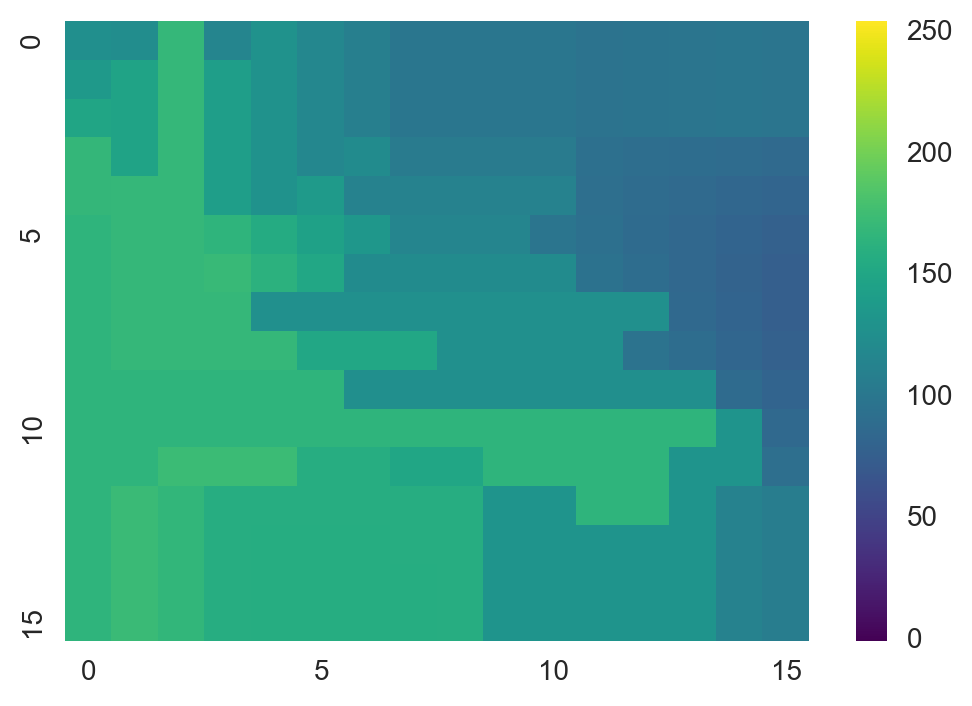

In [11]:
sns.heatmap(values, cmap='viridis', vmin=0, vmax=255, xticklabels=LABELS, yticklabels=LABELS)

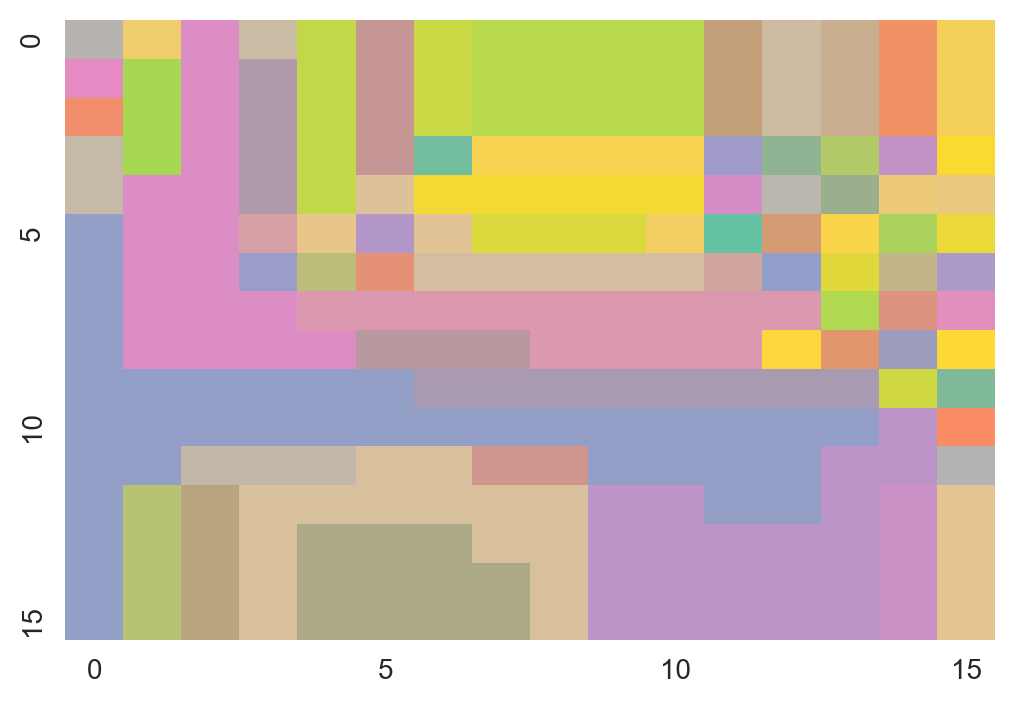

In [13]:
sns.heatmap(ids, cmap='Set2', xticklabels=LABELS, yticklabels=LABELS, cbar=False)